In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import funciones
import streamlit as st
from joblib import dump

In [2]:
df = pd.read_csv('cars.csv')

CAMBIAMOS NOMBRES DE LAS COLUMNAS

In [3]:
df.rename(columns={
    "mileage":"km",
    "make":"brand",
    "offerType":"type",
    "hp":"cv"
}, inplace=True)

ELIMINAMOS COLUMNAS NO NECESARIAS

In [4]:
df.drop(columns=["type"], inplace=True)

In [5]:
df.drop(columns=["model"], inplace=True)

In [6]:
df.drop(index=1824, inplace=True)

CAMBIAMOS LOS NOMBRES DE LAS MARCAS A TITLE

In [7]:
df["brand"] = df["brand"].str.title()

In [8]:
df["brand"] = df["brand"].replace("Maybach", "Mercedes-Benz")
df["brand"] = df["brand"].replace("Ds", "Citroen")

AREGLAMOS LA COLUMA DE FUEL

In [9]:
df["fuel"] = df["fuel"].replace({
    "Electric/Gasoline": "Hybrid",
    "Electric/Diesel": "Hybrid"
})

In [10]:
counts = df["fuel"].value_counts()

valid_fuels = counts[counts >= 150].index

# reemplazar los menos frecuentes por "Other"
df["fuel"] = df["fuel"].apply(lambda x: x if x in valid_fuels else "Other")

ARREGLAMOS LA COLUMNA DE GEAR

In [11]:
df["gear"] = df["gear"].replace({"Semi-automatic": "Automatic"})
df["gear"] = df["gear"].fillna("Unknown")

In [12]:
df = df[df["gear"] != 'Unknown']

ELIMINAMOS DUPLICADOS

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df = funciones.eliminar_fuel_other_en_duplicados(df) 

In [15]:
df = df.drop_duplicates(subset=["km", "price", "cv", "year"])

In [16]:
df.drop_duplicates(inplace=True)

FILTRAMOS POR PRECIO

In [17]:
df = df[df["price"] < 400000]

FILTRAMOS POR KM

In [18]:
df = df[df["km"] < 350000]

ARREGLAMOS LA COLUMA DE CV

In [19]:
df["cv"] = df["cv"] * 1.0139

In [20]:
df = df[df["cv"].notna()]

In [21]:
df["cv"] = df["cv"].round().astype(int)

In [22]:
df.to_csv("cars_limpio.csv", index=False)

In [23]:
df_filter_price = df[df['price']<100000]

In [24]:
df.describe()

,km,price,cv,year
count,43736.000000,43736.000000,43736.000000,43736.000000
mean,71537.122256,16479.972586,135.538732,2015.929600
std,59649.846889,17430.561172,76.178552,3.113971
min,0.000000,1100.000000,1.000000,2011.000000
25%,21606.750000,7490.000000,87.000000,2013.000000
50%,61100.000000,10990.000000,118.000000,2016.000000
75%,105500.000000,19500.000000,152.000000,2019.000000
max,349000.000000,399999.000000,862.000000,2021.000000


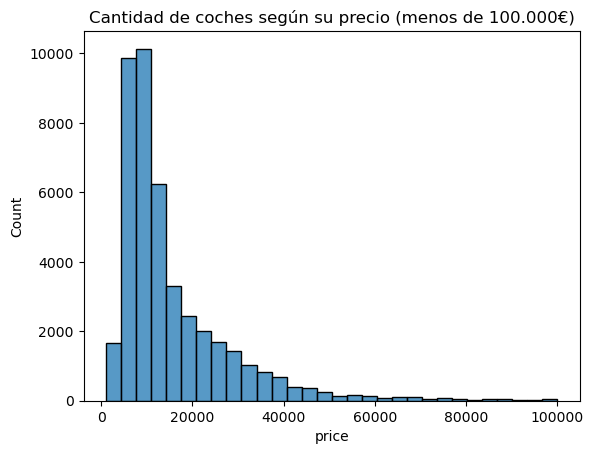

In [25]:
sns.histplot(df_filter_price["price"], bins=30)
plt.title("Cantidad de coches según su precio (menos de 100.000€)")
plt.show()

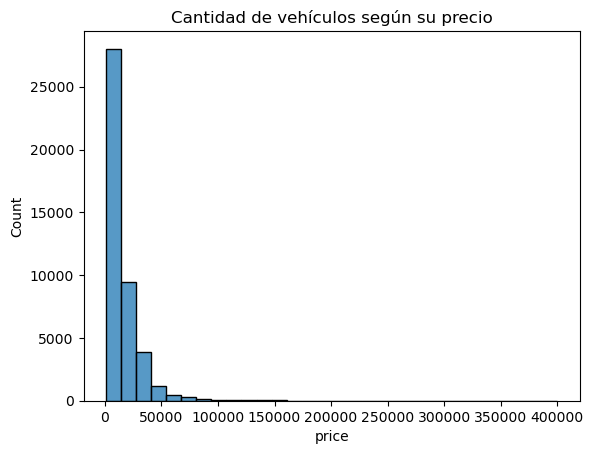

In [26]:
sns.histplot(df["price"], bins=30)
plt.title("Cantidad de vehículos según su precio")
plt.show()

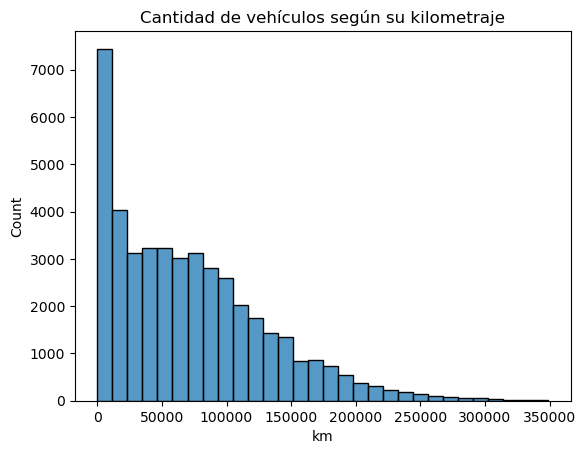

In [27]:
sns.histplot(df["km"], bins=30)
plt.title("Cantidad de vehículos según su kilometraje")
plt.show()

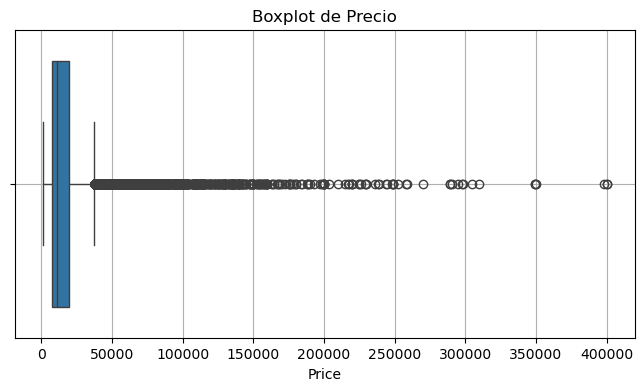

In [28]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["price"])
plt.title("Boxplot de Precio")
plt.xlabel("Price")
plt.grid(True)
plt.show()

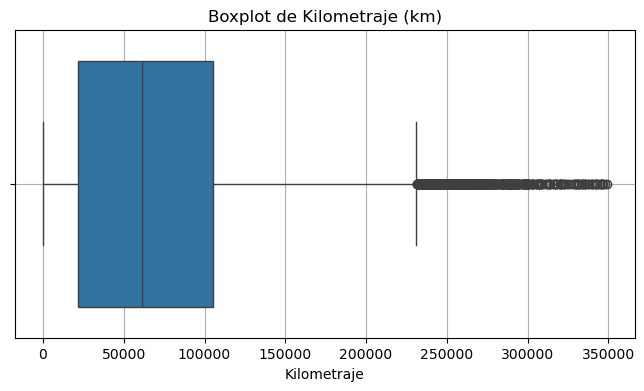

In [29]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["km"])
plt.title("Boxplot de Kilometraje (km)")
plt.xlabel("Kilometraje")
plt.grid(True)
plt.show()

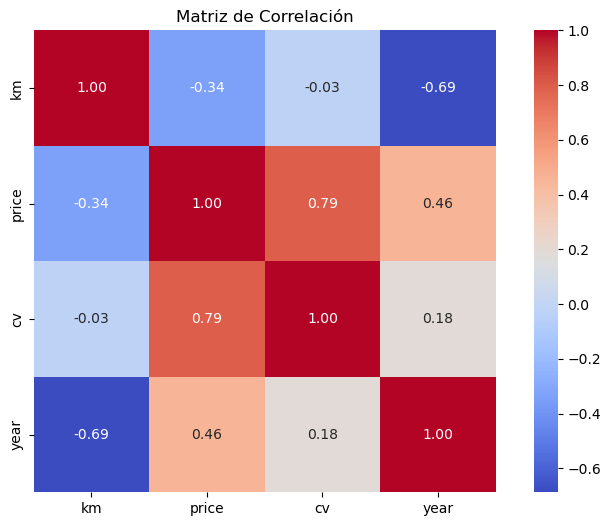

In [30]:
plt.figure(figsize=(10, 6))
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación")
plt.show()

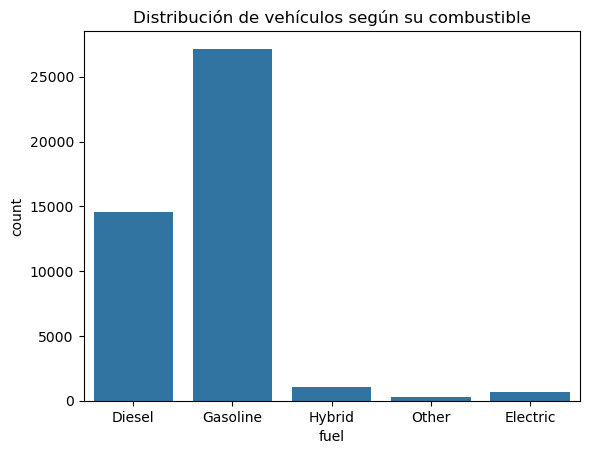

In [31]:
sns.countplot(x="fuel", data=df)
plt.title("Distribución de vehículos según su combustible")
plt.show()

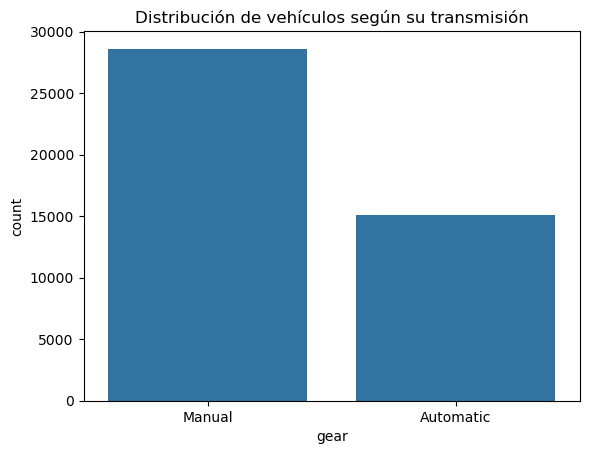

In [32]:
sns.countplot(x="gear", data=df)
plt.title("Distribución de vehículos según su transmisión")
plt.show()

HASTA AQUI LA LIMPIEZA

In [33]:
cat_columns = ['brand','fuel','gear']
dummies = pd.get_dummies(df[cat_columns], drop_first=True)

In [34]:
numerical = df[['km','cv','year']]

In [35]:
X = pd.concat([numerical, dummies], axis=1)
y = df["price"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

LINEAR REGRESSION

In [37]:
ln_rg = LinearRegression()

In [38]:
ln_rg.fit(X_train, y_train)

LinearRegression()

In [39]:
pred_ln_rg = ln_rg.predict(X_test)


print("MAE:", mean_absolute_error(y_test, pred_ln_rg))
print("RMSE:", mean_squared_error(y_test, pred_ln_rg, squared=False))
print("R2 SCORE:", r2_score(y_test, pred_ln_rg))

MAE: 3760.3748512797306
RMSE: 7298.001351817033
R2 SCORE: 0.8323472727727811


BAGGING AND PASTING

In [40]:
bagging = BaggingRegressor(DecisionTreeRegressor(max_depth=20), n_estimators=100, max_samples = 1000)

In [41]:
bagging.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pred_bag = bagging.predict(X_test)

print("MAE", mean_absolute_error(pred_bag, y_test))
print("RMSE", mean_squared_error(pred_bag, y_test, squared=False))
print("R2 score", bagging.score(X_test, y_test))

MAE 2552.9058907581602
RMSE 6155.16998391165
R2 score 0.8807432840287488


In [ ]:
bagging2 = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=200,
    bootstrap=True,       # True = Bagging
    random_state=42
)


In [ ]:
bagging2.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
pred_bag2 = bagging2.predict(X_test)

print("MAE", mean_absolute_error(pred_bag2, y_test))
print("RMSE", mean_squared_error(pred_bag2, y_test, squared=False))
print("R2 score", bagging2.score(X_test, y_test))

MAE 2154.3881764362395
RMSE 4700.48477713398
R2 score 0.9304514556494646


In [ ]:
pasting = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=100,
    bootstrap=False,      # False = Pasting
    random_state=42
)

pasting.fit(X_train, y_train)
pred_past = pasting.predict(X_test)

In [ ]:
pasting.fit(X_train, y_train)

BaggingRegressor(bootstrap=False, estimator=DecisionTreeRegressor(),
                 n_estimators=100, random_state=42)

In [ ]:
pred_past = pasting.predict(X_test)

print("MAE", mean_absolute_error(pred_past, y_test))
print("RMSE", mean_squared_error(pred_past, y_test, squared=False))
print("R2 score", pasting.score(X_test, y_test))

MAE 2768.5428142638575
RMSE 6208.153821768013
R2 score 0.8786813185004955


RANDOM FOREST

In [ ]:
forest = RandomForestRegressor(n_estimators=100,max_depth=25, random_state=42)

In [ ]:
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, random_state=42)

In [ ]:
pred_forest = forest.predict(X_test)

print("MAE", mean_absolute_error(pred_forest, y_test))
print("RMSE", mean_squared_error(pred_forest, y_test, squared=False))
print("R2 score", forest.score(X_test, y_test))

MAE 2147.0725597180844
RMSE 4688.560636763068
R2 score 0.9308038681160757


In [ ]:
forest2 = RandomForestRegressor(n_estimators=150, max_depth=20,random_state=42)

In [ ]:
forest2.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=150, random_state=42)

In [ ]:
pred_forest2 = forest2.predict(X_test)

print("MAE", mean_absolute_error(pred_forest2, y_test))
print("RMSE", mean_squared_error(pred_forest2, y_test, squared=False))
print("R2 score", forest2.score(X_test, y_test))

MAE 2129.1813789985545
RMSE 4664.051080518021
R2 score 0.9315254258673387


ADA BOOST

In [ ]:
adaboost = AdaBoostRegressor(n_estimators=100, estimator= DecisionTreeRegressor(max_depth=20),random_state=42)

In [ ]:
adaboost.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20),
                  n_estimators=100, random_state=42)

In [ ]:
pred_ada = adaboost.predict(X_test)

print("MAE", mean_absolute_error(pred_ada, y_test))
print("RMSE", mean_squared_error(pred_ada, y_test, squared=False))
print("R2 score", adaboost.score(X_test, y_test))

MAE 2635.088587944718
RMSE 5142.668338095198
R2 score 0.916750855955949


GRADIENT BOOST

In [ ]:
gradboost = GradientBoostingRegressor(n_estimators=100,max_depth=20,random_state=42)

In [ ]:
gradboost.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=20, random_state=42)

In [ ]:
pred_gb = gradboost.predict(X_test)

print("MAE", mean_absolute_error(pred_gb, y_test))
print("RMSE", mean_squared_error(pred_gb, y_test, squared=False))
print("R2 score", gradboost.score(X_test, y_test))

MAE 2539.525994350098
RMSE 5999.251027010565
R2 score 0.8867086341676523


In [ ]:
dump(forest2, 'random_forest_model.pkl')

['random_forest_model.pkl']